In [44]:
%reload_ext autoreload
%autoreload 2

In [79]:
import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from pprint import pprint

# REACH 2

In [81]:
gt_path = "./Data/Reach_2_GT_th26.tif"
pr_path = "./Data/Reach_2_prediction_wo_reg.tif"
unet_path = "./Data/Reach_2_UNet_prediction_th90.tif"

# Read Ground Truth

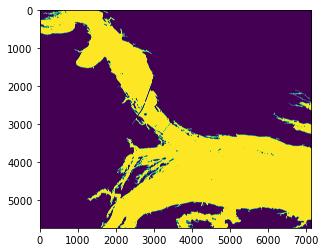

In [47]:
gt = gdal.Open(gt_path).ReadAsArray()
plt.imshow(gt)

# Read Prediction

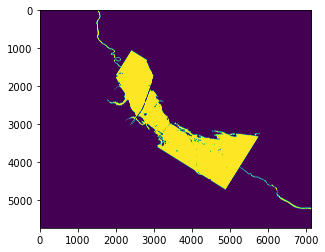

In [48]:
pr = gdal.Open(pr_path).ReadAsArray()
plt.imshow(pr)

# Read UNet Prediction

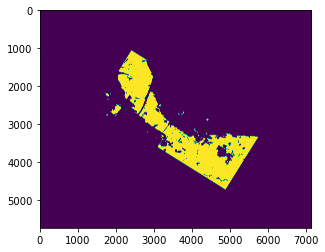

In [82]:
unet = gdal.Open(unet_path).ReadAsArray()
plt.imshow(unet)

In [83]:
def adjust_interpolated(image):
    new_array = np.zeros((image.shape[0], image.shape[1]))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] >= 0.5:
                new_array[i][j] = 1
    return new_array

# Rotate Ground Truth and Crop only RGB part

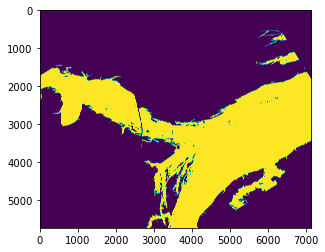

In [50]:
# dividing height and width by 2 to get the center of the image
height, width = gt.shape[:2]
# get the center coordinates of the image to create the 2D rotation matrix
center = (width/2, height/2)

# using cv2.getRotationMatrix2D() to get the rotation matrix
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=32, scale=1)

# rotate the image using cv2.warpAffine
gt_rotated = cv2.warpAffine(src=gt, M=rotate_matrix, dsize=(width, height))

plt.imshow(gt_rotated)

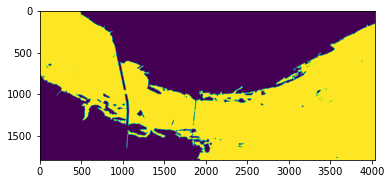

In [51]:
gt_rotated_cropped = gt_rotated[1951:3743, 1622:5654]
plt.imshow(gt_rotated_cropped)

In [52]:
gt_rotated_cropped_adj = adjust_interpolated(gt_rotated_cropped)

# Rotate Prediction and Crop only RGB part

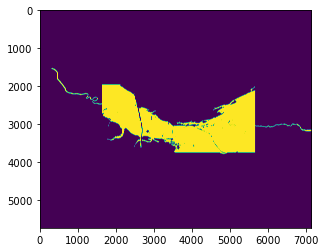

In [53]:
# dividing height and width by 2 to get the center of the image
height, width = pr.shape[:2]
# get the center coordinates of the image to create the 2D rotation matrix
center = (width/2, height/2)

# using cv2.getRotationMatrix2D() to get the rotation matrix
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=32, scale=1)

# rotate the image using cv2.warpAffine
pr_rotated = cv2.warpAffine(src=pr, M=rotate_matrix, dsize=(width, height))

plt.imshow(pr_rotated)

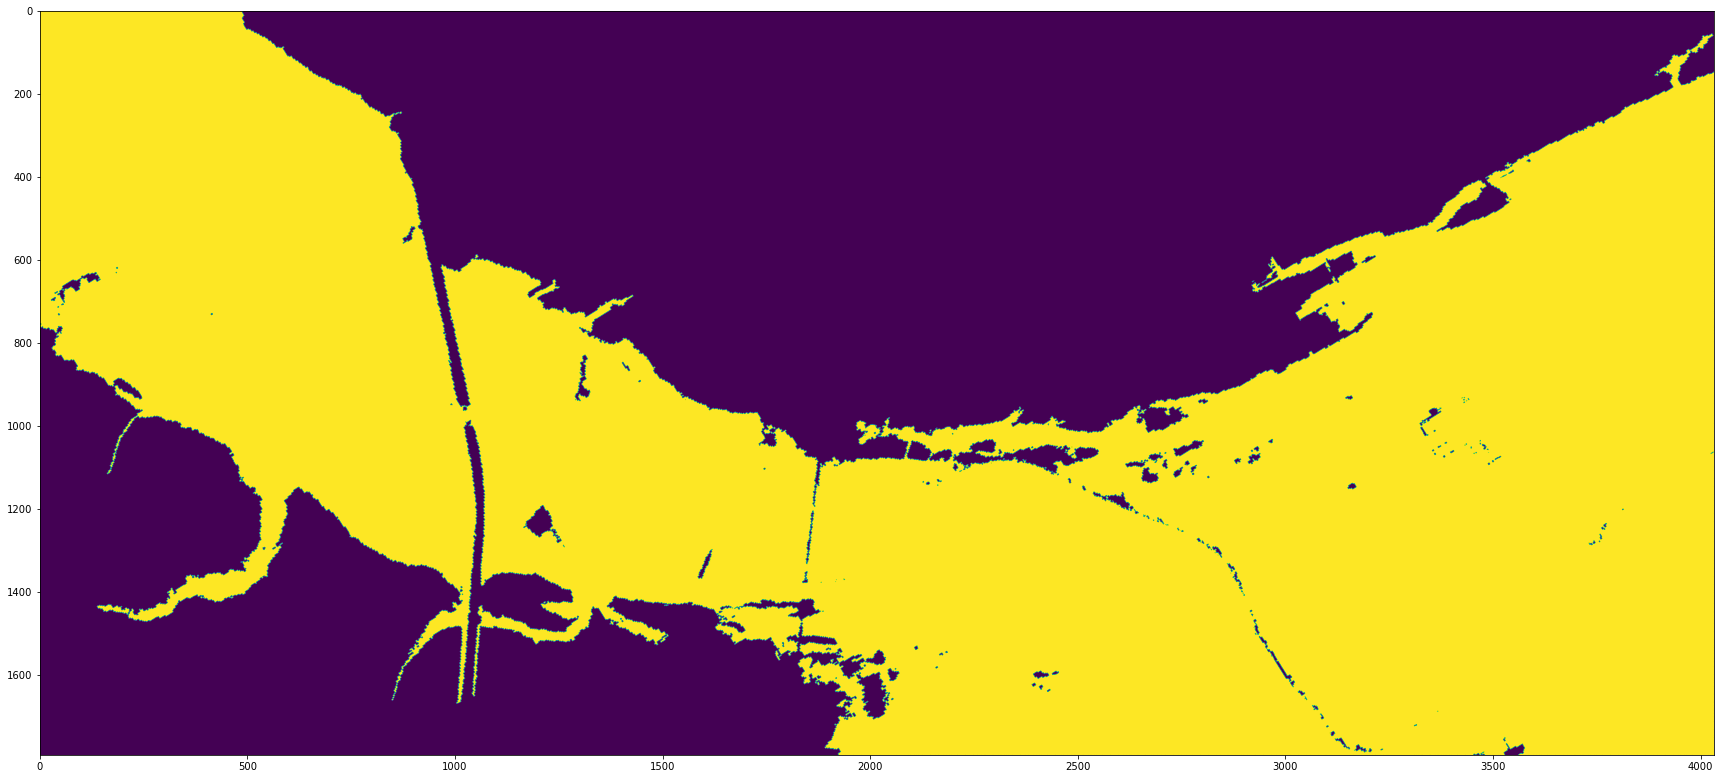

In [54]:
pr_rotated_cropped = pr_rotated[1951:3743, 1622:5654]
plt.figure(figsize=(30,30))
plt.imshow(pr_rotated_cropped)

# Rotate UNet Prediction and Crop only RGB part

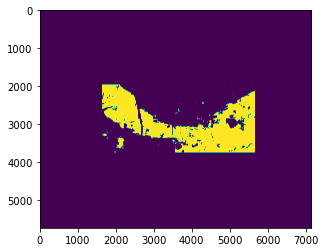

In [84]:
# dividing height and width by 2 to get the center of the image
height, width = unet.shape[:2]
# get the center coordinates of the image to create the 2D rotation matrix
center = (width/2, height/2)

# using cv2.getRotationMatrix2D() to get the rotation matrix
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=32, scale=1)

# rotate the image using cv2.warpAffine
unet_rotated = cv2.warpAffine(src=unet, M=rotate_matrix, dsize=(width, height))

plt.imshow(unet_rotated)

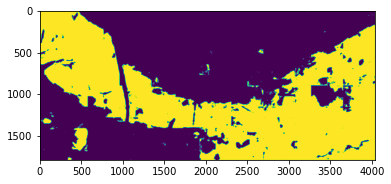

In [85]:
unet_rotated_cropped = unet_rotated[1951:3743, 1622:5654]
plt.imshow(unet_rotated_cropped)

In [52]:
gt_rotated_cropped_adj = adjust_interpolated(gt_rotated_cropped)

In [55]:
pr_rotated_cropped_adj = adjust_interpolated(pr_rotated_cropped)

In [86]:
unet_rotated_cropped_adj = adjust_interpolated(unet_rotated_cropped)

In [87]:
pr_rotated_cropped_adj.shape, gt_rotated_cropped_adj.shape, unet_rotated_cropped_adj.shape

((1792, 4032), (1792, 4032), (1792, 4032))

In [88]:
np.unique(pr_rotated_cropped_adj), np.unique(gt_rotated_cropped_adj), np.unique(unet_rotated_cropped_adj)

(array([0., 1.]), array([0., 1.]), array([0., 1.]))

# Get the Metrics

In [89]:
def get_metrics(conf_matrix):
    metric = {"Dry": {}, "Flood": {}}
    c = conf_matrix
    TP_0 = c[0][0]
    FP_0 = c[1][0]
    FN_0 = c[0][1]
    TN_0 = c[1][1]

    TP_1 = c[1][1]
    FP_1 = c[0][1]
    FN_1 = c[1][0]
    TN_1 = c[0][0]

    Accuracy_0 = (TP_0 + TN_0)/(TP_0 + FP_0 + TN_0 + FN_0)
    Precision_0 = TP_0 / (TP_0 + FP_0)
    Recall_0 = TP_0 / (TP_0 + FN_0)
    F1_0 = (2 * Precision_0 * Recall_0) / (Precision_0 + Recall_0)

    Accuracy_1 = (TP_1 + TN_1)/(TP_1 + FP_1 + TN_1 + FN_1)
    Precision_1 = TP_1 / (TP_1 + FP_1)
    Recall_1 = TP_1 / (TP_1 + FN_1)
    F1_1 = (2 * Precision_1 * Recall_1) / (Precision_1 + Recall_1)

    metric["Dry"]["Accuracy"] = Accuracy_0
    metric["Dry"]["Precision"] = Precision_0
    metric["Dry"]["Recall"] = Recall_0
    metric["Dry"]["F1"] = F1_0

    metric["Flood"]["Accuracy"] = Accuracy_1
    metric["Flood"]["Precision"] = Precision_1
    metric["Flood"]["Recall"] = Recall_1
    metric["Flood"]["F1"] = F1_1

    return metric

In [60]:
pr_rotated_cropped_adj_copy = np.copy(pr_rotated_cropped_adj)
pr_rotated_cropped_adj_copy.shape = pr_rotated_cropped_adj_copy.shape[0]*pr_rotated_cropped_adj_copy.shape[1]
pr_rotated_cropped_adj_copy = np.array(pr_rotated_cropped_adj_copy)

In [61]:
gt_rotated_cropped_adj_copy = np.copy(gt_rotated_cropped_adj)
gt_rotated_cropped_adj_copy.shape = gt_rotated_cropped_adj_copy.shape[0]*gt_rotated_cropped_adj_copy.shape[1]
gt_rotated_cropped_adj_copy = np.array(gt_rotated_cropped_adj_copy)

In [90]:
unet_rotated_cropped_adj_copy = np.copy(unet_rotated_cropped_adj)
unet_rotated_cropped_adj_copy.shape = unet_rotated_cropped_adj_copy.shape[0]*unet_rotated_cropped_adj_copy.shape[1]
unet_rotated_cropped_adj_copy = np.array(unet_rotated_cropped_adj_copy)

In [91]:
pr_rotated_cropped_adj_copy.shape, gt_rotated_cropped_adj_copy.shape, unet_rotated_cropped_adj_copy.shape

((7225344,), (7225344,), (7225344,))

# Get HMT Metrics

In [92]:
cm_hmt = confusion_matrix(gt_rotated_cropped_adj_copy, pr_rotated_cropped_adj_copy, labels=[0,1])

In [93]:
cm_hmt

array([[3366766,  160319],
       [  51642, 3646617]])

In [94]:
metrics_hmt = get_metrics(cm_hmt)

In [97]:
pprint(metrics_hmt)

{'Dry': {'Accuracy': 0.9706642341181264,
         'F1': 0.9694822239400429,
         'Precision': 0.9848929677206466,
         'Recall': 0.9545463179934706},
 'Flood': {'Accuracy': 0.9706642341181264,
           'F1': 0.9717580955591426,
           'Precision': 0.9578876555844386,
           'Recall': 0.9860361321367703}}


# Get UNet Metrics

In [98]:
cm_unet = confusion_matrix(gt_rotated_cropped_adj_copy, unet_rotated_cropped_adj_copy, labels=[0,1])

In [99]:
cm_unet

array([[3425538,  101547],
       [ 583721, 3114538]])

In [100]:
metrics_unet = get_metrics(cm_unet)

In [101]:
pprint(metrics_unet)

{'Dry': {'Accuracy': 0.9051577336663832,
         'F1': 0.9090715604277088,
         'Precision': 0.8544067619477814,
         'Recall': 0.9712093697770255},
 'Flood': {'Accuracy': 0.9051577336663832,
           'F1': 0.9008918271928618,
           'Precision': 0.9684252748294899,
           'Recall': 0.8421632990009623}}


#######################################################

# REACH 0

In [80]:
gt_path = "./Data/Reach_0_GT_th26.tif"
pr_path = "./Data/Reach_0_prediction_wo_reg.tif"

# Read Ground Truth

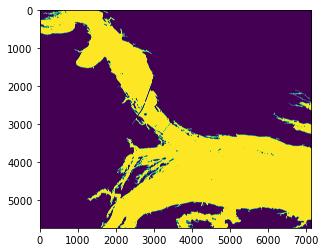

In [47]:
gt = gdal.Open(gt_path).ReadAsArray()
plt.imshow(gt)

# Read Prediction

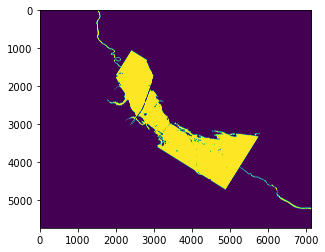

In [48]:
pr = gdal.Open(pr_path).ReadAsArray()
plt.imshow(pr)

# Read UNet Prediction

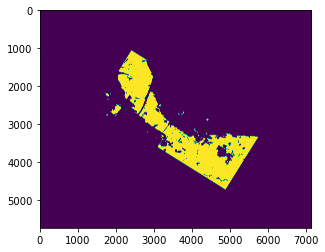

In [82]:
unet = gdal.Open(unet_path).ReadAsArray()
plt.imshow(unet)

In [49]:
def adjust_interpolated(image):
    new_array = np.zeros((image.shape[0], image.shape[1]))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] >= 0.5:
                new_array[i][j] = 1
    return new_array

# Rotate Ground Truth and Crop only RGB part

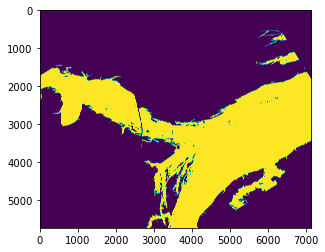

In [50]:
# dividing height and width by 2 to get the center of the image
height, width = gt.shape[:2]
# get the center coordinates of the image to create the 2D rotation matrix
center = (width/2, height/2)

# using cv2.getRotationMatrix2D() to get the rotation matrix
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=37.3, scale=1)

# rotate the image using cv2.warpAffine
gt_rotated = cv2.warpAffine(src=gt, M=rotate_matrix, dsize=(width, height))

plt.imshow(gt_rotated)

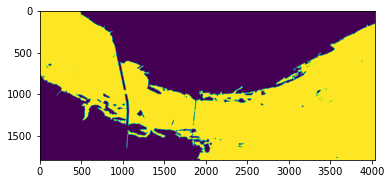

In [51]:
gt_rotated_cropped = gt_rotated[2569:5705, 2008:8480]
plt.imshow(gt_rotated_cropped)

In [52]:
gt_rotated_cropped_adj = adjust_interpolated(gt_rotated_cropped)

# Rotate Prediction and Crop only RGB part

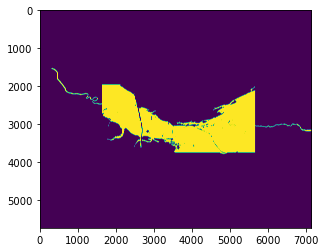

In [53]:
# dividing height and width by 2 to get the center of the image
height, width = pr.shape[:2]
# get the center coordinates of the image to create the 2D rotation matrix
center = (width/2, height/2)

# using cv2.getRotationMatrix2D() to get the rotation matrix
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=37.3, scale=1)

# rotate the image using cv2.warpAffine
pr_rotated = cv2.warpAffine(src=pr, M=rotate_matrix, dsize=(width, height))

plt.imshow(pr_rotated)

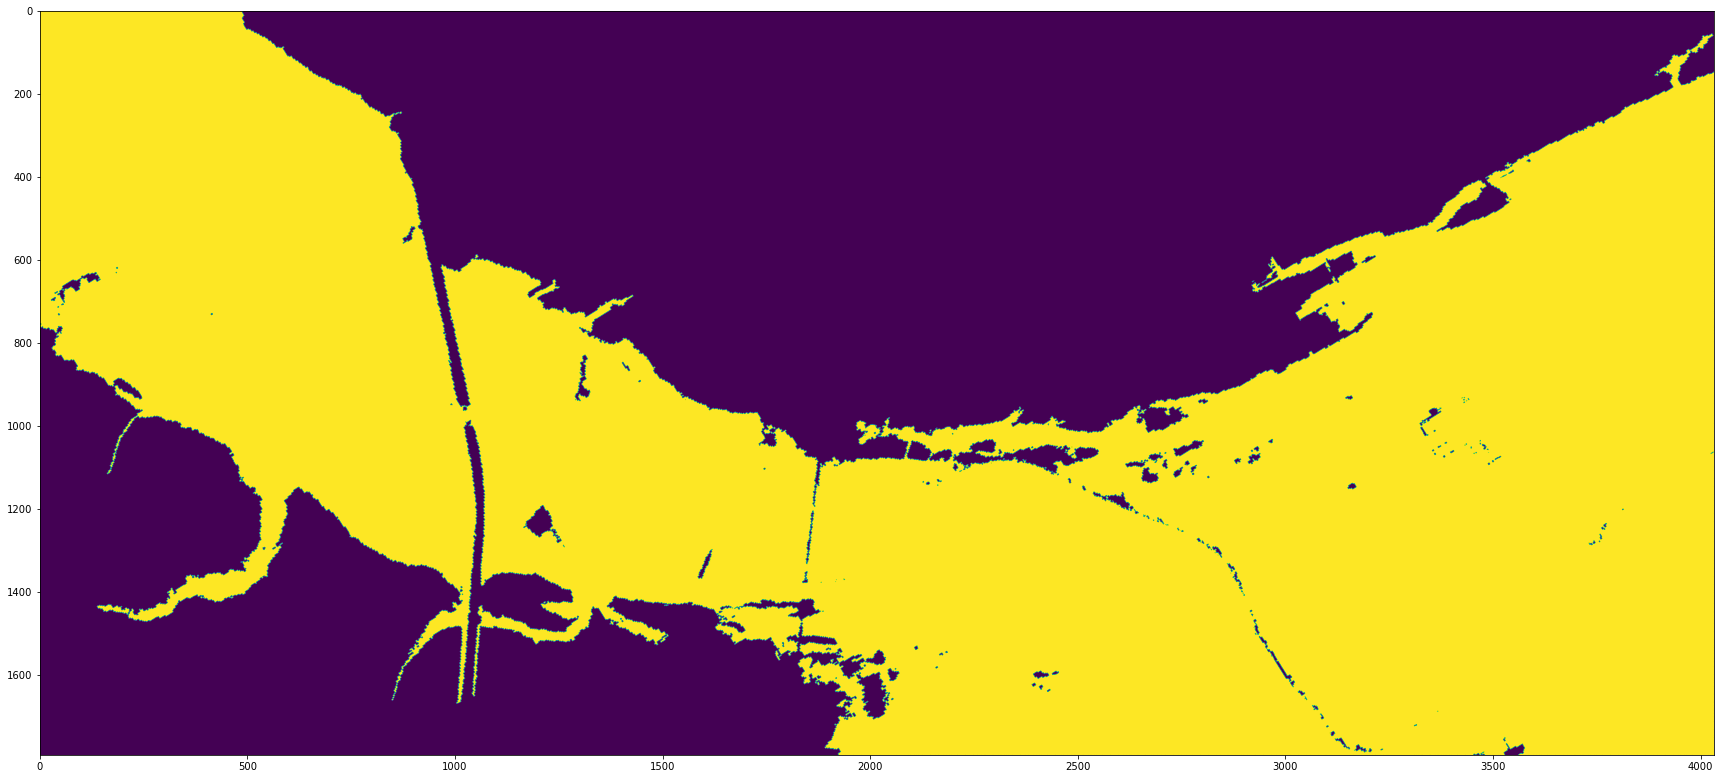

In [54]:
pr_rotated_cropped = pr_rotated[2569:5705, 2008:8480]
plt.figure(figsize=(30,30))
plt.imshow(pr_rotated_cropped)

In [55]:
pr_rotated_cropped_adj = adjust_interpolated(pr_rotated_cropped)

# Rotate UNet Prediction and Crop only RGB part

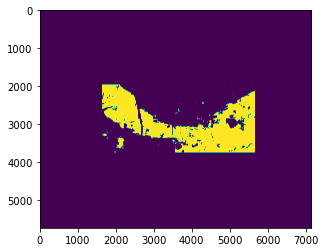

In [84]:
# dividing height and width by 2 to get the center of the image
height, width = unet.shape[:2]
# get the center coordinates of the image to create the 2D rotation matrix
center = (width/2, height/2)

# using cv2.getRotationMatrix2D() to get the rotation matrix
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=37.3, scale=1)

# rotate the image using cv2.warpAffine
unet_rotated = cv2.warpAffine(src=unet, M=rotate_matrix, dsize=(width, height))

plt.imshow(unet_rotated)

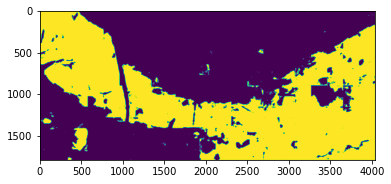

In [85]:
unet_rotated_cropped = unet_rotated[2569:5705, 2008:8480]
plt.imshow(unet_rotated_cropped)

In [ ]:
unet_rotated_cropped_adj = adjust_interpolated(unet_rotated_cropped)

In [56]:
pr_rotated_cropped_adj.shape, gt_rotated_cropped_adj.shape, unet_rotated_cropped_adj.shape

((1792, 4032), (1792, 4032))

In [57]:
np.unique(pr_rotated_cropped_adj), np.unique(gt_rotated_cropped_adj), np.unique(unet_rotated_cropped_adj)

(array([0., 1.]), array([0., 1.]))

# Get the Metrics

In [75]:
def get_metrics(conf_matrix):
    metric = {"Dry": {}, "Flood": {}}
    c = conf_matrix
    TP_0 = c[0][0]
    FP_0 = c[1][0]
    FN_0 = c[0][1]
    TN_0 = c[1][1]

    TP_1 = c[1][1]
    FP_1 = c[0][1]
    FN_1 = c[1][0]
    TN_1 = c[0][0]

    Accuracy_0 = (TP_0 + TN_0)/(TP_0 + FP_0 + TN_0 + FN_0)
    Precision_0 = TP_0 / (TP_0 + FP_0)
    Recall_0 = TP_0 / (TP_0 + FN_0)
    F1_0 = (2 * Precision_0 * Recall_0) / (Precision_0 + Recall_0)

    Accuracy_1 = (TP_1 + TN_1)/(TP_1 + FP_1 + TN_1 + FN_1)
    Precision_1 = TP_1 / (TP_1 + FP_1)
    Recall_1 = TP_1 / (TP_1 + FN_1)
    F1_1 = (2 * Precision_1 * Recall_1) / (Precision_1 + Recall_1)

    metric["Dry"]["Accuracy"] = Accuracy_0
    metric["Dry"]["Precision"] = Precision_0
    metric["Dry"]["Recall"] = Recall_0
    metric["Dry"]["F1"] = F1_0

    metric["Flood"]["Accuracy"] = Accuracy_1
    metric["Flood"]["Precision"] = Precision_1
    metric["Flood"]["Recall"] = Recall_1
    metric["Flood"]["F1"] = F1_1

    return metric

In [59]:
pr_rotated_cropped.shape

(1792, 4032)

In [60]:
pr_rotated_cropped_adj_copy = np.copy(pr_rotated_cropped_adj)
pr_rotated_cropped_adj_copy.shape = pr_rotated_cropped_adj_copy.shape[0]*pr_rotated_cropped_adj_copy.shape[1]
pr_rotated_cropped_adj_copy = np.array(pr_rotated_cropped_adj_copy)

In [61]:
gt_rotated_cropped_adj_copy = np.copy(gt_rotated_cropped_adj)
gt_rotated_cropped_adj_copy.shape = gt_rotated_cropped_adj_copy.shape[0]*gt_rotated_cropped_adj_copy.shape[1]
gt_rotated_cropped_adj_copy = np.array(gt_rotated_cropped_adj_copy)

In [ ]:
unet_rotated_cropped_adj_copy = np.copy(unet_rotated_cropped_adj)
unet_rotated_cropped_adj_copy.shape = unet_rotated_cropped_adj_copy.shape[0]*unet_rotated_cropped_adj_copy.shape[1]
unet_rotated_cropped_adj_copy = np.array(unet_rotated_cropped_adj_copy)

In [62]:
pr_rotated_cropped_adj_copy.shape, gt_rotated_cropped_adj_copy.shape, unet_rotated_cropped_adj_copy.shape

((7225344,), (7225344,))

# Metrics HMT

In [66]:
cm_hmt = confusion_matrix(gt_rotated_cropped_adj_copy, pr_rotated_cropped_adj_copy, labels=[0,1])

In [67]:
cm_hmt

array([[3366766,  160319],
       [  51642, 3646617]])

In [76]:
metrics_hmt = get_metrics(cm_hmt)

In [78]:
pprint(metrics_hmt)

{'Dry': {'Accuracy': 0.9706642341181264,
         'F1': 0.9694822239400429,
         'Precision': 0.9848929677206466,
         'Recall': 0.9545463179934706},
 'Flood': {'Accuracy': 0.9706642341181264,
           'F1': 0.9717580955591426,
           'Precision': 0.9578876555844386,
           'Recall': 0.9860361321367703}}


# Get UNet Metrics

In [98]:
cm_unet = confusion_matrix(gt_rotated_cropped_adj_copy, unet_rotated_cropped_adj_copy, labels=[0,1])

In [99]:
cm_unet

array([[3425538,  101547],
       [ 583721, 3114538]])

In [100]:
metrics_unet = get_metrics(cm_unet)

In [101]:
pprint(metrics_unet)

{'Dry': {'Accuracy': 0.9051577336663832,
         'F1': 0.9090715604277088,
         'Precision': 0.8544067619477814,
         'Recall': 0.9712093697770255},
 'Flood': {'Accuracy': 0.9051577336663832,
           'F1': 0.9008918271928618,
           'Precision': 0.9684252748294899,
           'Recall': 0.8421632990009623}}
